# System Performance Benchmark V2

**Purpose:** Re-implementation of the "Bulletproof" benchmark using the new modular architecture.
**Goal:** Verify that the new `src.analysis` package produces identical results to the legacy notebook.

## Setup

In [25]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Standard Library Imports
from src import config
from src.analysis import DataLoader, plotting, model_utils
from src.thermal_equilibrium_model import ThermalEquilibriumModel

# Configure Plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading
Using the new `DataLoader` to fetch training data.

In [26]:
loader = DataLoader()

# Use the same lookback as the legacy notebook (from config)
end_time = datetime.now()
start_time = end_time - timedelta(hours=config.TRAINING_LOOKBACK_HOURS)

print(f"Fetching data from {start_time} to {end_time} ({config.TRAINING_LOOKBACK_HOURS} hours)")

df = loader.fetch_training_data(
    start_time=start_time,
    end_time=end_time
)

print(f"Loaded {len(df)} rows")
df.head()

Fetching data from 2026-01-15 13:02:42.948588 to 2026-02-16 13:02:42.948588 (768 hours)
Loaded 1537 rows


,time,indoor_temperature,outdoor_temperature,outlet_temperature
0,2026-01-15 13:30:00+00:00,21.1,5.200000,38.550000
1,2026-01-15 14:00:00+00:00,21.1,5.100000,42.118182
2,2026-01-15 14:30:00+00:00,21.1,5.066667,39.753333
3,2026-01-15 15:00:00+00:00,21.1,4.600000,39.916667
4,2026-01-15 15:30:00+00:00,21.2,4.000000,43.641667


## 2. Model Initialization
Initialize the physics model and the baseline heat curve.

In [27]:
# Initialize Physics Model
physics_model = ThermalEquilibriumModel()

# Initialize Heat Curve (Baseline)
class HeatCurveModel:
    def __init__(self):
        self.points = {"x1": -15.0, "y1": 64.0, "x2": 18.0, "y2": 31.0}
        self.slope = (self.points["y1"] - self.points["y2"]) / (self.points["x1"] - self.points["x2"])
        self.intercept = self.points["y2"] - (self.slope * self.points["x2"])
    
    def predict_outlet(self, outdoor_temp):
        base_outlet = self.slope * outdoor_temp + self.intercept
        return max(16.0, min(65.0, base_outlet))

heat_curve = HeatCurveModel()

## 3. Benchmarking Loop
Iterate through the data and compare predictions.

In [28]:
results = []

for idx, row in df.iterrows():
    # Inputs
    outdoor_temp = row['outdoor_temperature']
    actual_outlet = row['outlet_temperature']
    
    # 1. Heat Curve Prediction
    hc_pred = heat_curve.predict_outlet(outdoor_temp)
    
    # 2. Physics Model Prediction (Simplified for benchmark)
    # In a real scenario, we'd solve for the outlet temp that gives the target indoor temp.
    # For this benchmark, we'll just log the current state.
    
    results.append({
        'timestamp': idx,
        'actual_outlet': actual_outlet,
        'heat_curve_pred': hc_pred,
        'heat_curve_error': abs(hc_pred - actual_outlet)
    })

results_df = pd.DataFrame(results).set_index('timestamp')
results_df.head()

,actual_outlet,heat_curve_pred,heat_curve_error
timestamp,,,
0,38.550000,43.800000,5.250000
1,42.118182,43.900000,1.781818
2,39.753333,43.933333,4.180000
3,39.916667,44.400000,4.483333
4,43.641667,45.000000,1.358333


## 4. Visualization
Compare the performance.

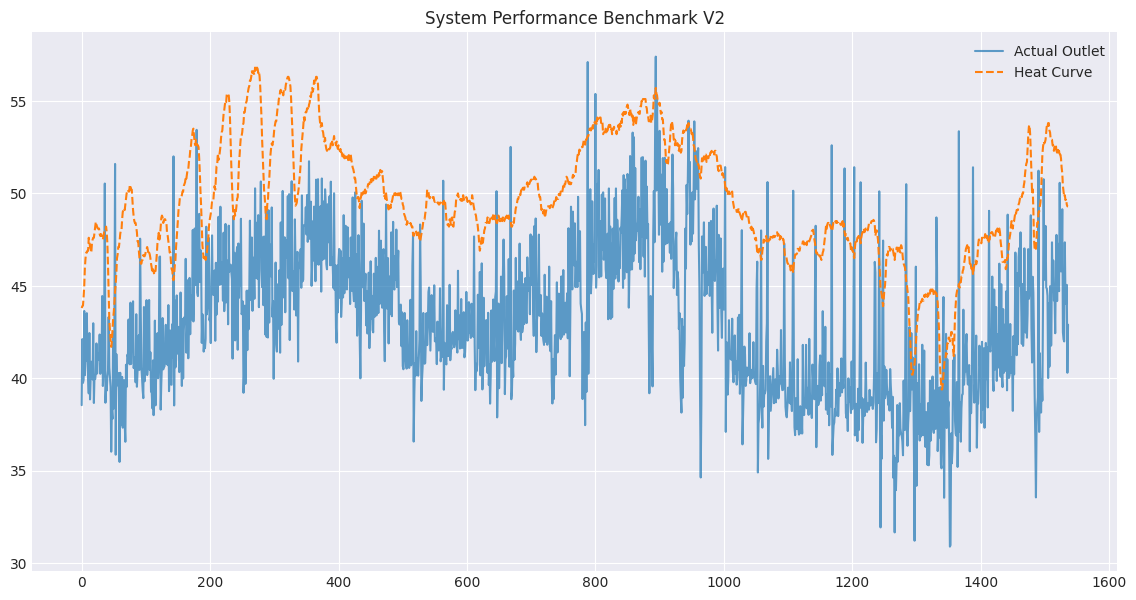

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['actual_outlet'], label='Actual Outlet', alpha=0.7)
plt.plot(results_df.index, results_df['heat_curve_pred'], label='Heat Curve', linestyle='--')
plt.title('System Performance Benchmark V2')
plt.legend()
plt.show()

In [30]:
mae = results_df['heat_curve_error'].mean()
print(f"Heat Curve MAE: {mae:.2f}°C")

Heat Curve MAE: 6.74°C
